In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Preface

## about this document

Welcome to the main pipeline of minian!
The purpose of this annotated version of the minian pipeline is to guide the user through each step of the code, working with a short demo movie.
The intention is to enable the user to understand the code as much as possible so that they are equipped with the knowledge necessary to customize the code for their own needs, regardless of prior programming skills.

Before we start, it s highly recommended that you get familiar with basic python concepts and operations like [string manipulation](https://docs.python.org/3/library/string.html), [tuples, lists and dictionaries](https://docs.python.org/3/tutorial/datastructures.html).

The notes in this pipeline are supposed to give you minimal amount of knowledge to walkthrough the pipeline and touch on parameters that are most commonly tweaked.
The [Minian readthedocs](https://minian.readthedocs.io) site contains more comprehensive documentations.
In particular, the [API reference](https://minian.readthedocs.io/page/api/index.html) contains detailed documentation of every minian function.
Be sure to check them out whenever you are puzzled by how to specify parameters!

## text styling

Note on the styling of this document: most of the sentences should hopefully make sense if taken literally.
However, some special formatting of the text is used to demonstrate the close relationship between the concepts discussed and the code, as well as encouraging the reader to understand the Python syntax.
Specifically:

-  a [hyperlink](https://en.wikipedia.org/wiki/Hyperlink) usually points to a well-defined python module, class or methods, especially when that concept is first encountered in this document.
    The link usually points to the official documentation of that concept, which in some cases might not be the best place to start for a beginner.
    If you find the documentation puzzling, try to google the concept in question and find a tutorial that best suits you.
-  an inline `code` usually refers to a name that already exsists in the [namespace](https://docs.python.org/3/tutorial/classes.html#python-scopes-and-namespaces) (i.e. the context where we run the codes in this document).
    It can be a previously encountered concept, but more often it referes to variable names or method names that we [imported](https://docs.python.org/3/reference/import.html) or have defined along the way.
-  **bold** texts are used more loosely to highlight anything that requires more attention.
    Though they are not used as carefully as previous formats, they often refer to specific values that a variable or method arguments can assume.
-  <div class="alert alert-info">
    
    Info boxes are used to provide hints and tips to help users run through this pipeline smoothly.
    </div>

## workflow

There are 5 main sections in this pipeline: Setting up, Pre-processing, Motion Correction, Initialization, and CNMF, which are composed of interative spatial update and temporal update.

![workflow](img/workflow.png)

# Setting Up

The cells under this section should be executed every time the kernel is restarted.

## load modules

Loads the minian modules, usually this cell should not be modified.

In [2]:
%%capture
%load_ext autoreload
%autoreload 2
import itertools as itt
import os
import sys

import holoviews as hv
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from holoviews.operation.datashader import datashade, regrid
from holoviews.util import Dynamic
from IPython.core.display import display

## set path and parameters

Set all of the parameters that control the notebook’s behavior.
Ideally, the following cell is the only part of the code the user will have to change when analyzing different datasets.
Here we briefly introduce only some of the initial parameters that are necessary to start the pipeline, and leave the discussion of specific parameters for later.

* `minian_path` is the path that contains the **minian** folder , where the minian codebase (.py files) reside.
    The default value `"."` means “current folder”, which should work in most cases, unless you want to try out another version of minian that is not in the same folder as this notebook.

* `dpath` is the folder that contains the videos to be processed.

* `interactive` controls whether interactive plots will be shown for parameters exploration.
    Interactive plotting requires CPU/memory usage, and thus could require some time (in particular, those steps where video is played).
    In principle, the user might want to visualize interactive plots during the initial parameters exploration, once the parameters are set and ready for batch processing, the user will set interactive as False to reduce processing time.

* `output_size` controls the relative size of all the plots on a scale of 0-100 percent, though it can be set to values >100 without any problem. 

* `param_save_minian` specifies the destination folder and format of the saved data.
    `dpath` is the folder path  where  the data will be saved.
    `meta_dict` is a `dictionary` that is used to construct meta data for the final labeled data structure.
    `overwrite` is a boolean value controlling whether the data is overwritten if a file already exists.
    We set it to `True` here so you can easily play with the demo multiple times, but **use caution** with this option during actual analysis.
    In addition to erasing prior data that may be important to you, overwritting data may cause compatibility issues with existing data from the same minian dataset folder.
    If you want to re-analyze a video from scratch using different parameters, it is recommended that you delete existing data first.

<div class="alert alert-info">
<strong>folder structure</strong>

The defult `meta_dict` in `param_save_minian` assumes output minian datasets are stored in heirarchiically arranged folders, as shown below:

```
mice1  
│
└───session1
│   │
│   └───minian
│       │   Y.zarr
│       │   A.zarr
│       │   ...
│   
└───session2
    │
    └───minian
```

The default value can be read as follows:
The name of the last folder (`-1`) in `dpath` (the folder that directly contains the videos) will be used to designate the value of a metadata dimension named `"session"`.
The name of the second-to-last folder (`-2`) in `dpath` will be used to designate the value for `"animal"` and so on.
Both the keys (name of metadata dimension) and values (numbers indicating which level of folder name should be used) of `meta_dict` can be modified to represent your preferred way of data storage. 
Note that the metadata are determined by the folder structure of saved minian datasets, not by those of input movie data.
</div>

In [3]:
# Set up Initial Basic Parameters#
minian_path = "."
dpath = '/mnt/working_storage/5116/2022_12_15/13_15_15'
minian_ds_path = os.path.join(dpath, "minian")
intpath = os.path.join(dpath,'minian_intermediate_2')
subset = dict(frame=slice(0, None))
subset_mc = None
interactive = True
output_size = 100
output_modifier = 0.4
n_workers = int(os.getenv("MINIAN_NWORKERS", 10))
param_save_minian = {
    "dpath": minian_ds_path,
    "meta_dict": dict(session=-1, animal=-2),
    "overwrite": True,
}

# Pre-processing Parameters#
param_load_videos = {
    "pattern": "concat_scopedownsample_normcorr_rigid.avi",
    "dtype": np.uint8,
    "downsample": dict(frame=1,height=1,width=1),
    "downsample_strategy": "subset",
}
param_denoise = {"method": "median", "ksize": 7}
param_background_removal = {"method": "tophat", "wnd": 15}

# Motion Correction Parameters#
subset_mc = None
param_estimate_motion = {"dim": "frame"}

# Initialization Parameters#
param_seeds_init = {
    "wnd_size": 1000,
    "method": "rolling",
    "stp_size": 500,
    "max_wnd": 15,
    "diff_thres": 3,
}
param_pnr_refine = {"noise_freq": 0.06, "thres": 1}
param_ks_refine = {"sig": 0.05}
param_seeds_merge = {"thres_dist": 10, "thres_corr": 0.8, "noise_freq": 0.06}
param_initialize = {"thres_corr": 0.8, "wnd": 10, "noise_freq": 0.06}
param_init_merge = {"thres_corr": 0.8}

# CNMF Parameters#
param_get_noise = {"noise_range": (0.06, 0.5)}
param_first_spatial = {
    "dl_wnd": 10,
    "sparse_penal": 0.01,
    "size_thres": (25, None),
}
param_first_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": 1,
    "p": 1,
    "add_lag": 20,
    "jac_thres": 0.2,
}
param_first_merge = {"thres_corr": 0.8}
param_second_spatial = {
    "dl_wnd": 10,
    "sparse_penal": 0.01,
    "size_thres": (25, None),
}
param_second_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": 1,
    "p": 1,
    "add_lag": 20,
    "jac_thres": 0.4,
}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MINIAN_INTERMEDIATE"] = intpath

## import minian

The following cell loads **minian** and usually should not be modified. If you encounter an `ImportError`, check that you followed the installation instructions and that `minian_path` is pointing to the right place.

In [4]:
%%capture
sys.path.append(minian_path)
from minian.cnmf import (
    compute_AtC,
    compute_trace,
    get_noise_fft,
    smooth_sig,
    unit_merge,
    update_spatial,
    update_temporal,
    update_background,
)
from minian.initialization import (
    gmm_refine,
    initA,
    initC,
    intensity_refine,
    ks_refine,
    pnr_refine,
    seeds_init,
    seeds_merge,
)
from minian.motion_correction import apply_transform, estimate_motion
from minian.preprocessing import denoise, remove_background
from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)
from minian.visualization import (
    CNMFViewer,
    VArrayViewer,
    generate_videos,
    visualize_gmm_fit,
    visualize_motion,
    visualize_preprocess,
    visualize_seeds,
    visualize_spatial_update,
    visualize_temporal_update,
    write_video,
)

## module initialization

The following cell handles initialization of modules and parameters necessary for minian to be run and usually should not be modified.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
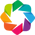

In [5]:
dpath = os.path.abspath(dpath)
hv.notebook_extension("bokeh", width=100)

## start cluster

In [6]:
#phil said in talk to decrease memory limit as much as you can, but increase
#number of workers instead. suggested no lower than 2GB. so I dunno, i did 5 cause I have 
#a lot. Once you have 'enough' memory, increasing doesnt improve performance. but increasing
#workers might. workers should be no more than 1 / computer core. I have 12 cores, 
#so i guess I could go up to 12. I set the default to 10 (os.getenv("MINIAN_WORKERS", 10)) 
#sets the default to 10 if not defined in the env.

cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit="5GB",
    resources={"MEM": 1},
    threads_per_worker=2,
    dashboard_address=":8787",
)
annt_plugin = TaskAnnotation()
cluster.scheduler.add_plugin(annt_plugin)
client = Client(cluster)

/home/dprotter/anaconda3/envs/minian/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46575 instead
  warnings.warn(


# Pre-processing

In the pre-processing steps that follow, the pipeline will load and process the videos  (downsampling, subsetting, denoising).

All functions are evaluated lazily, which means that initially only a “plan” for the actual computation will be created, without its execution. Actual computations are carried out only when results are being saved

## loading videos and visualization

Recall the values of `param_load_videos`:

In [7]:
param_load_videos

{'pattern': 'concat_scopedownsample_normcorr_rigid.avi',
 'dtype': numpy.uint8,
 'downsample': {'frame': 1, 'height': 1, 'width': 1},
 'downsample_strategy': 'subset'}

The first argument of load_videos should be the path that contains the videos(`dpath`).
We then pass the dictionary, `param_load_videos`, defined earlier, which specifies several relevant arguments.
The argument `pattern` is optional and is the [regular expression](https://docs.python.org/3/library/re.html) used to filter files under the specified folder.
The default value `r"msCam[0-9]+\.avi$"` means that a file can only be loaded if its filename contains **'msCam'**, followed by at least one number, then **'.avi'** as the end of the filename.
This can be changed to suit the naming convention of your videos.
The resulting "video array" `varr` contains three dimensions: `height`, `width`, and `frame`.
If you wish to downsample the video, pass in a dictionary to `downsample`, with the name of dimensions as keys and  the downsampling folds as integer value.
For example, `downsample=dict("frame"=2)` will temporally downsample the video with a factor of 2.
`downsample_strategy` will assume two values: either `"subset"`, meaning downsampling are carried out simply by subsetting the data, or `"mean"`, meaning a mean will be calculated on the window of downsampling (the latter being slower).

In addition to the video array `varr`, the following cell also try to estimate best chunk size `chk` to use for computations.
This variable is needed for later steps since it's important to keep chunk size consistent within the pipeline.
If for some reason you have to restart the kernel at some point, remember to either note down the content of `chk` or rerun the following cell.

<div class="alert alert-info">
<strong>changing parameters</strong>

All minian parameters are `dict` and you can freely change them in various ways.
You can go back to the initial parameter setting cell and change things there.
Alternatively, you can add a code cell before running the relevant step.
For example, the following line will tell the function to load from `"/my/data_path"`:
```python
param_load_videos["vapth"] = "/my/data_path"
```
While the following line will change the downsample setting (which is specified as a `dict` on its own) when loading the video:
```python
param_load_videos["downsample"] = {"frame": 2}
```
</div>

In [8]:
interactive = False

In [9]:

varr = load_videos(dpath, **param_load_videos)
#varr = varr.sel(frame = slice(61, None))
chk, _ = get_optimal_chk(varr, dtype=float)




video list is: ['/mnt/working_storage/5116/2022_12_15/13_15_15/2022_12_15__13_15_15__5116_concat_scopedownsample_normcorr_rigid.avi']
loading 1 videos in folder /mnt/working_storage/5116/2022_12_15/13_15_15


In [10]:
varr

<xarray.DataArray 'fluorescence' (frame: 20594, height: 300, width: 300)>
dask.array<from-value, shape=(20594, 300, 300), dtype=uint8, chunksize=(20594, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 ... 20588 20589 20590 20591 20592 20593
  * height   (height) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * width    (width) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299

We then immediately save the array representation to the intermediate folder to avoid repeatedly loading the video in later steps.

In [11]:
%%time
varr = save_minian(
    varr.chunk({"frame": chk["frame"], "height": -1, "width": -1}).rename("varr"),
    intpath,
    overwrite=True,
)

CPU times: user 1.02 s, sys: 312 ms, total: 1.33 s
Wall time: 15.5 s


The variable `varr` is a [xarray.DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray).
Now is a perfect time to familiarize yourself with this data structure and the [xarray](https://xarray.pydata.org/en/stable/) module in general, since we will be using these data structures throughout the analysis.
Basically, a `xarray.DataArray` is N-dimensional array labeled with additional metadata, with many useful properties that make them easy to manipulate.
We can ask the computer to print out some information of `varr` by calling it (as with any other variable):

In [12]:
varr

<xarray.DataArray 'varr' (frame: 20594, height: 300, width: 300)>
dask.array<from-zarr, shape=(20594, 300, 300), dtype=uint8, chunksize=(372, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 ... 20588 20589 20590 20591 20592 20593
  * height   (height) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * width    (width) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299

We can see now that `varr` is a `xarray.DataArray` with a [name](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.name.html#xarray.DataArray.name) `"demo_movies"` and three dimensions: `frame`, `height` and `width`.
Each dimension is labeled with ascending natural numbers.
The [dtype](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.dtype.html#xarray.DataArray.dtype) ([data type](https://docs.scipy.org/doc/numpy-1.14.0/user/basics.types.html)) of `varr` is `numpy.uint8`.

## visualize raw data and optionally set roi for motion correction

Once the data is loaded we can visualize the content of `varr` with the help of `VArrayViewer`, which shows the array as a movie.
You can also plot summary traces like mean fluorescence across `frames` by passing a `list` of names of traces as inputs.
Currently `"mean"`, `"min"`, `"max"` and `"diff"` are supported, where `"diff"` is mean fluorescent value difference across all pixels in a frame.

`VArrayViewer` also supports a box drawing tool where you can draw a box in the field of view (FOV) and save it as a mask using the `“save mask”` button.
The mask is saved as `vaviewer.mask`, and can be retrieved and used at later stages, for example, when you want to run motion correction on a sub-region of the FOV.
See the [API reference](https://minian.readthedocs.io/page/api/minian.visualization.html#minian-visualization-VArrayViewer) for more detail.

In [13]:
hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(varr, framerate=5, summary=["mean", "max"])
    display(vaviewer.show())

If you decide to set a mask for motion correction, the following cell is an example of how to convert the mask into a `subset_mc` parameter that can be later passed into motion correction functions.

In [14]:
if interactive:
    try:
        subset_mc = list(vaviewer.mask.values())[0]
    except IndexError:
        pass

In [15]:
subset_mc

In [16]:
if not subset_mc:
    subset_mc = {'height': slice(63.51875000000004, 526.71875, None),
                 'width': slice(82.68124999999998, 547.08125, None)}

## subset part of video

Before proceeding to pre-processing, it’s good practice to check if there is anything obviously wrong with the video (e.g. the camera suddenly dropped, resulting in dark frames).
This can usually be observed by visualizing the video and plotting the timecourse of the mean fluorescence.
We can utilize the [xarray.DataArray.sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html) method and [slice](https://docs.python.org/3/library/functions.html#slice) to subset any part of the data we want.
By default `subset = None` will result in no subsetting.

<div class="alert alert-info">
<strong>subsetting data</strong>

The [xarray.DataArray.sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html) method takes in either a `dict` or keyword arguments.
In both cases you want to specify the dimension names and the coordinates of the subset as key-value pairs.
For example, say you want only the first 800 frames of the video, the following two lines will both work and they are equivalent:
```python
varr.sel(frame=slice(0, 799)) # slice object is inclusive on both ends
varr.sel({"frame": slice(0, 799)})
```
This also works on arbitrary dimensions.
For example, the following will give you a 100px x 100px chunk of your movie at a corner:
```python
varr.sel(height=slice(0, 99), width=slice(0, 99))
```
</div>

In [17]:
varr_ref = varr.sel(subset)

## glow removal and visualization

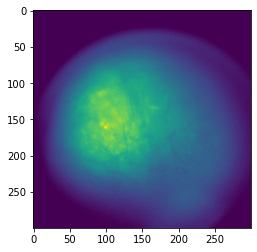

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(varr_ref[1])

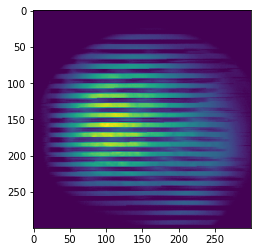

In [19]:
plt.figure()
plt.imshow(varr_ref.min("frame").compute())

Here we remove the general glow background caused by vignetting effect.
We simply calculate a minimum projection across all `frame`s and subtract that projection from all `frame`s.
A benefit of doing this is you could interpret the result as "change of fluorescence from baseline", while preserving the linear scale of the raw data, which is usually the range of a 8-bit integer -- 0-255.
The result can be visualized again with `VArrayViewer`.

In [20]:
import matplotlib.pyplot as plt

In [21]:
hv.Image(varr[-1], ['width', 'height']).opts(cmap='viridis', frame_width = 500, frame_height=500)

:Image   [width,height]   (varr)

In [22]:
%%time
%matplotlib notebook


varr_min = varr_ref.min("frame").compute()
varr_ref = varr_ref - varr_min
'''plt.figure()
plt.imshow(varr_min)'''
hv.Image(varr_min, ['width', 'height']).opts(cmap='viridis', frame_width = 500, frame_height=500)

CPU times: user 189 ms, sys: 28.3 ms, total: 217 ms
Wall time: 490 ms


:Image   [width,height]   (varr)

In [23]:
hv.Image(varr_ref[-1], ['width', 'height']).opts(cmap='viridis', frame_width = 500, frame_height=500)

:Image   [width,height]   (varr)

In [24]:
hv.output(size=int(output_size*0.5 ))
if interactive:
    vaviewer = VArrayViewer(
        [varr.rename("original"), varr_ref.rename("glow_removed")],
        framerate=10,
        summary=None,
        layout=True,
    )
    display(vaviewer.show())

In [25]:
hv.Image(varr_min, ['width', 'height']).opts(cmap='viridis', frame_width = 500, frame_height=500)

:Image   [width,height]   (varr)

## denoise

Recall that by default we use a median filter for denoising:

In [26]:
hv.Image(varr_ref.max('frame').compute(), ['width', 'height']).opts(cmap='viridis', frame_width = 500, frame_height=500)

:Image   [width,height]   (varr)

In [27]:
param_denoise

{'method': 'median', 'ksize': 7}

There is only one parameter controlling how the filtering is done: the kernel size (`ksize`) of the filter.
The effect of this parameter can be visualized with the tool below.
Alternatively other methods like gaussian filter, anisotropic filter etc. are implmented as well.
See the [API reference](https://minian.readthedocs.io/page/api/minian.preprocessing.html#minian-preprocessing-denoise) for `denoise` for more detail.

<div class="alert alert-info">

Generally `ksize=5` is good (approximately half the diamater of the largest cell).
Note that if you do want to play with the ksize, it has to be odd number.
</div>

In [28]:
m = varr_ref.max('frame').compute()
hv.output(size=int(output_size * 1))
if interactive:
    display(
        visualize_preprocess(
           m,
            denoise,
            method=["median"],
            ksize=[3,5, 7, 9,11,13],
        )
    )

The following cell would carry out denoise step.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [29]:
param_denoise['ksize'] = 3
varr_ref = denoise(varr_ref, **param_denoise)

## background removal

Recall the parameters for background removal:

In [30]:
param_background_removal

{'method': 'tophat', 'wnd': 15}

This step attempts to estimate background (everything except the fluorescent signal of in-focus cells) and subtracts it from the frame.
By default we use a morphological tophat operation to estimate the background from each frame:
First, a [disk element](http://scikit-image.org/docs/dev/api/skimage.morphology.html#disk) with a radius of `wnd` is created.
Then, a [morphological erosion](https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm) using the disk element is applied to each frame, which eats away any bright "features" that are smaller than the disk element.
Subsequently, a [morphological dilation](https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm) is applied to the "eroded" image, which in theory undoes the erosion except the bright "features" that were completely eaten away.
The overall effect of this process is to remove any bright feature that is smaller than a disk with radius `wnd`.
Thus, when setting `wnd` to the **largest** expected radius of cell, this process can give us a good estimation of the background.
Then finally the estimated background is subtracted from each frame.

<div class="alert alert-info">

Pragmatically `wnd=15` works well.
</div>

In [31]:
hv.output(size=int(output_size * 1))
if interactive:
    display(
        visualize_preprocess(
            varr_ref.max('frame').compute(),
            remove_background,
            method=["tophat"],
            wnd=[5,10, 15, 20],
        )
    )

The following cell would carry out background removal step.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [32]:
param_background_removal['wnd'] = 10
varr_ref = remove_background(varr_ref, **param_background_removal)


In [33]:
'''varr_ref = varr_ref.drop_sel(frame = len(varr_ref)-1)
hv.Image(varr_ref[-1], ['width', 'height']).opts(cmap='viridis', frame_width = 500, frame_height=500)'''

"varr_ref = varr_ref.drop_sel(frame = len(varr_ref)-1)\nhv.Image(varr_ref[-1], ['width', 'height']).opts(cmap='viridis', frame_width = 500, frame_height=500)"

## save result

Here we are saving our pre-processed video (`varr_ref`) into the intermediate folder (`intpath`).
Note that for every saved variable a separate folder will be created based on the `.name` attribute of that variable.
And variables with the same `.name` attribute will be saved to same folder regardless the variable name, potentially overwritting each other!
Here we [rename](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rename.html) it to `"varr_ref"` so that the saved folder will be named "varr_ref.zarr".

In [34]:
%%time
varr_ref = save_minian(varr_ref.rename("varr_ref"), dpath=intpath, overwrite=True)

CPU times: user 533 ms, sys: 92.2 ms, total: 625 ms
Wall time: 4.2 s


# Motion Correction

## estimate motion

Recall the parameters for `estimate_motion`:

In [35]:
param_estimate_motion

{'dim': 'frame'}

By default the motion estimation process is simple: for each pair of frames it calculates a [phase correlation](https://en.wikipedia.org/wiki/Phase_correlation) between the two frames using [fft](https://en.wikipedia.org/wiki/Fast_Fourier_transform).
Then the peak of the phase correlation will correspond to the translational shift between the two frames.
The argument `dim` specifies along which dimension to run the motion estimation, and should always be set to `"frame"` here.
Usually this step is parameter-free, but see [API reference](https://minian.readthedocs.io/page/api/minian.motion_correction.html#minian-motion_correction-estimate_motion) for `estimate_motion` for more advanced tweaking of the parameters.
By default, the results from `estimate_motion` are saved in a two dimensional `DataArray` called `motion`, with two labels on the `shift_dim` dimension, representing the shifts along `"height"` and `"width"` directions.

In [36]:
varr_ref.sel(subset_mc)

<xarray.DataArray 'varr_ref' (frame: 20594, height: 236, width: 217)>
dask.array<getitem, shape=(20594, 236, 217), dtype=uint8, chunksize=(372, 236, 217), chunktype=numpy.ndarray>
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 ... 20588 20589 20590 20591 20592 20593
  * height   (height) int64 64 65 66 67 68 69 70 ... 293 294 295 296 297 298 299
  * width    (width) int64 83 84 85 86 87 88 89 ... 293 294 295 296 297 298 299

In [37]:
%%time
motion = estimate_motion(varr_ref.sel(subset_mc), **param_estimate_motion)

CPU times: user 135 ms, sys: 201 µs, total: 135 ms
Wall time: 131 ms


## save motion

Here is the first time we save a variable to the final output folder using `param_save_minian`:

In [38]:
param_save_minian

{'dpath': '/mnt/working_storage/5116/2022_12_15/13_15_15/minian',
 'meta_dict': {'session': -1, 'animal': -2},
 'overwrite': True}

As mentioned before `param_save_minian` decides how your data will be saved and what metadata will be stored.
Additionally we use the `chk` variable earlier to make sure all our data have same chunk size along same dimension.

In [39]:
%%time
motion = save_minian(
    motion.rename("motion").chunk({"frame": chk["frame"]}), **param_save_minian
)

CPU times: user 4.19 s, sys: 1.02 s, total: 5.22 s
Wall time: 51.9 s


## visualization of motion

Here we visualize `motion` as a fluctuating curve across `frame`s.

In [40]:
hv.output(size=output_size)
visualize_motion(motion)

:NdOverlay   [Element]
   :Curve   [frame]   (motion)

## apply transform

After determining each frame's motion, we use the function `apply_transform` to correct for the motion.
Notably, we have to decide what to do with pixels that are shifted from outside of the FOV.
The default is to fill them with 0. 

In [41]:
Y = apply_transform(varr_ref, motion, fill=0)

## save result

Here we save two versions of the motion-corrected movie `Y`.
Their contents are identical.
The only difference is how they are chunked.
Also note that we convert the data to `float` type for better downstream processing.

In [42]:
%%time
Y_fm_chk = save_minian(Y.astype(float).rename("Y_fm_chk"), intpath, overwrite=True)
Y_hw_chk = save_minian(
    Y_fm_chk.rename("Y_hw_chk"),
    intpath,
    overwrite=True,
    chunks={"frame": -1, "height": chk["height"], "width": chk["width"]},
)

CPU times: user 2.51 s, sys: 760 ms, total: 3.27 s
Wall time: 16.7 s


## visualization of motion-correction

Here we visualize the result of motion correction `Y_fm_chk` side by side with input `varr_ref`.

In [43]:
hv.output(size=int(output_size * output_modifier))
if interactive:
    vaviewer = VArrayViewer(
        [varr_ref.rename("before_mc"), Y_fm_chk.rename("after_mc")],
        framerate=60,
        summary=None,
        layout=True,
    )
    display(vaviewer.show())

A potentially better visualization is to look at max projcetion across all frames before and after the motion correction.
You should see that the cells after motion correction have much more defined borders.

In [44]:
max_proj_pre = varr_ref.max("frame").compute().astype(np.float32)
max_proj_img = Y_hw_chk.max("frame").compute()

In [45]:

im_opts = dict(
    frame_width=800,
    aspect=varr_ref.sizes["width"] / varr_ref.sizes["height"],
    cmap="Viridis",
    colorbar=True,
)
(
    regrid(
        hv.Image(
            max_proj_pre,
            ["width", "height"],
            label="before_mc",
        ).opts(**im_opts)
    )
    + regrid(
        hv.Image(
            max_proj_img.astype(np.float32),
            ["width", "height"],
            label="after_mc",
        ).opts(**im_opts)
    )
)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Image   [width,height]   (varr_ref)
   .DynamicMap.II :DynamicMap   []
      :Image   [width,height]   (Y_hw_chk)

In [46]:
dpath

'/mnt/working_storage/5116/2022_12_15/13_15_15'

## generate video for motion-correction

Finally, we can generate a mp4 video for the original movie and motion-corrected movie side-by-side so that we can play it back at original speed.

In [47]:
%%time
vid_arr = xr.concat([varr_ref, Y_fm_chk], "width").chunk({"width": -1})
write_video(vid_arr, "minian_mc.mp4", dpath)

CPU times: user 6.96 s, sys: 7.52 s, total: 14.5 s
Wall time: 1min 1s


'/mnt/working_storage/5116/2022_12_15/13_15_15/minian_mc.mp4'

# Initialization

In order to run CNMF, we first need to generate an initial estimate of where our cells are likely to be and what their temporal activity is likely to look like.
The whole initialization section is adapted from the [MIN1PIPE](https://github.com/JinghaoLu/MIN1PIPE) package.
See the [paper](https://www.cell.com/cell-reports/fulltext/S2211-1247(18)30826-X) for full details about the theory.

## compute max projection

Here we calculate a max projection that will be used later.
We also save this max projection in the output data folder, since it will be useful when carrying out cross-session registrations.

In [48]:
max_proj = save_minian(
    Y_fm_chk.max("frame").rename("max_proj"), **param_save_minian
).compute()

## generating over-complete set of seeds

We first generate an over-complete set of **seeds**.
Recall the parameters:

In [49]:
param_seeds_init['diff_thres'] = 3.5

The idea is that we select some subset of frames, compute a max projection of those frames, and find the local maxima of that max projection.
We keep repeating this process and we collect all the local maxima until we obtain an overly-complete set of local maximas, which are the potential locations of cells, which we call **seeds**.
The assumption here is that the center of cells are brighter than their surroundings on some, but not necessarily all, frames.
There are several parameters controlling how we subset the frames:
By default we use `method="rolling"`, which use a rolling window across time to chunk and compute max projections.
`wnd_size` controls the number of frames in each chunk.
`stp_size` is the distance between the center of each chunk.
For example, if `wnd_size=100` and `stp_size=50`, the windows will be as follows: (0, 100), (50, 150), (100, 200)...
Alternatively you can use `method="random"` to use random sampling of frames instead of rolling window.
See the [API reference](https://minian.readthedocs.io/page/api/minian.initialization.html#minian-initialization-seeds_init) of `seeds_init` for details.
Additionally we have two parameters controlling how the local maxima are found.
`max_wnd` controls the window size within which a single pixel will be choosen as local maxima.
In order to capture cells with all sizes, we actually find local maximas with different window size and merge all of them, starting from 2 all the way up to `max_wnd`.
Hence `max_wnd` should be the radius of the **largest** cell you want to detect.
Finally in order to get rid of local maxima with very little fluctuation, we set a `diff_thres` which is the minimal fluorescent diffrence of a seed across `frame`s.
Since the linear scale of the raw data is preserved, we can set this threshold empirically.

In [50]:
%%time
seeds = seeds_init(Y_fm_chk, **param_seeds_init)

constructing chunks
computing max projections
calculating local maximum
CPU times: user 2.04 s, sys: 296 ms, total: 2.33 s
Wall time: 8.32 s


The `seeds` variable is a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), with each row representing a seed.
The column "height" and "width" defines the location of the seed.
The column "seeds" is the number of chunks where the particular seed/pixel is considered a local maxima.

In [51]:
seeds.head()

height  width  seeds
0       0     85    2.0
1       0     86   17.0
2       0    139    2.0
3       0    140    4.0
4       0    143    1.0

We can visualize the seeds as points overlaid on top of the `max_proj` image. Each white dot is a seed and could potentially be the location of a cell. 

In [52]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds)

:Overlay
   .Image.I  :Image   [width,height]   (max_proj)
   .Points.I :Points   [width,height]   (seeds)

## peak-noise-ratio refine

Next, we refine seeds based upon their temporal activity.
This requires that we separate our signal from noise based upon frequency.
To find the best cut-off frequency, we are going to take a few example seeds and separate their activity with different cut-off frequencies.
We will then view the results and select a frequency which we believe best separates signal from noise.

This is a complicated part in the pipeline, but it is important to understand since the idea is used later and it will allow you to do parameter exploration based on your need.
The basic idea is to run some function on a small subset of the data using different parameters within a for loop, and then visualizing the results using `holoviews`.

We will go line by line:

1. First we create a `list` of frequencies we want to test -- `noise_freq_list`.
    The "frequency" values here are a fraction of your **sampling rate**.
    Note that if you have temporally downsampled, the fraction here is relative to the downsampled rate.
1. Then we randomly select 6 rows from `seeds` and call them `example_seeds`.
1. Then we pull out the corresponding temporal activities of the 6 selected seeds and assign it to `example_trace`.
1. We then create an empty dictionary `smooth_dict` to store the resulting visualizations.
1. After initializing these variables, we use a `for` loop to iterate through `noise_freq_list`, with one of the values from the list as `freq` during each iteration.
1. Within the loop, we run `smooth_sig` twice on `example_trace` with the current `freq` we are testing out.
    The low-passed result is assigned to `trace_smth_low`, while the high-pass result is assigned to `trace_smth_high`.
1. Then we make sure to actually carry-out the computation by calling the `compute` method on the resulting `DataArray`s.
1. Next, we turn the two traces into visualizations:
    we construct interactive line plots ([hv.Curve](http://holoviews.org/reference/elements/bokeh/Curve.html)s) from them and put them in a container called a [hv.HoloMap](http://holoviews.org/reference/containers/bokeh/HoloMap.html).
1. Finally, we store the whole visualization in `smooth_dict`, with the keys being the `freq` and values corresponding to the result of this iteration.

<div class="alert alert-info">

So if you want to customize the parameter values to explore, in this case the cut-off frequency to test, you can edit `noise_freq_list`.
</div>

In [53]:
%%time
if interactive:
    noise_freq_list = [0.005, 0.01, 0.02, 0.06, 0.1, 0.2, 0.3, 0.45, 0.6, 0.8]
    example_seeds = seeds.sample(6, axis="rows")
    example_trace = Y_hw_chk.sel(
        height=example_seeds["height"].to_xarray(),
        width=example_seeds["width"].to_xarray(),
    ).rename(**{"index": "seed"})
    smooth_dict = dict()
    for freq in noise_freq_list:
        trace_smth_low = smooth_sig(example_trace, freq)
        trace_smth_high = smooth_sig(example_trace, freq, btype="high")
        trace_smth_low = trace_smth_low.compute()
        trace_smth_high = trace_smth_high.compute()
        hv_trace = hv.HoloMap(
            {
                "signal": (
                    hv.Dataset(trace_smth_low)
                    .to(hv.Curve, kdims=["frame"])
                    .opts(frame_width=300, aspect=2, ylabel="Signal (A.U.)")
                ),
                "noise": (
                    hv.Dataset(trace_smth_high)
                    .to(hv.Curve, kdims=["frame"])
                    .opts(frame_width=300, aspect=2, ylabel="Signal (A.U.)")
                ),
            },
            kdims="trace",
        ).collate()
        smooth_dict[freq] = hv_trace

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs


At the end of the process, we put together a `smooth_dict`.
Here we convert that into an interactive plot, from which we can determine the frequency that best separates noise and signal.

In [54]:
interactive = True
hv.output(size=int(output_size * 0.7))
if interactive:
    hv_res = (
        hv.HoloMap(smooth_dict, kdims=["noise_freq"])
        .collate()
        .opts(aspect=2)
        .overlay("trace")
        .layout("seed")
        .cols(3)
    )
    display(hv_res)

NameError: name 'smooth_dict' is not defined

<div class="alert alert-info">
<strong>picking noise frequency</strong>

We can now use the interactive visualization to pick the best cut-off frequency.
Here is an example of what you might see:

<div stype="clear:both"><img src="img/param_pnr.png" style="width: 50%"/></div>

We are looking for the frequency that can best seperate real signal from noise.
Hence, `noise_freq=0.005` in the example is not ideal, since real calcium activities are overly smoothed as well.
At the same time, `noise_freq=0.45` is not ideal either, since a lot of high-frequency noise are visible in the signal.
Hence, `noise_freq=0.05` in the middle is a good choice in this example.
Now, say you already found your parameters, it's time now to pass them in! Either go back to initial parameters setting step and modify them there, or call the parameter here and change its value/s accordingly.
</div>

Having determined the frequency that best separates signal from noise, we move on to peak-noise-ratio refining.
Recall the parameters:

In [ ]:
param_pnr_refine['noise_freq'] = 0.05

First we filter the temporal activities for each seed using the `noise_freq` we choose.
**signal** is defined as the low-pass filtered temporal signal, while **noise** is high-pass filtered signal.
Then we compute the peak-to-peak value (max minus min) for both the **real** signal and **noise** signal.
The peak-noise-ratio is defined as the ratio between the peak-to-peak value of **signal** and that of **noise**.
We then threshold the seeds based on this peak-noise-ratio, with the assumption that temporal activities from real cells should have higher fluctuation in the low-frequency range and lower fluctuation in the high-frequency range.
`thres` is the threshold for peak-noise-ratios.
Pragmatically `thres=1` works fine and makes sense.
You can also use `thres="auto"`, where a gaussian mixture model with 2 components will be run on the peak-noise-ratios and seeds will be selected if they belong to the "higher" gaussian.

The following cell would carry out pnr refinement step.
Be sure to [change](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) the `noise_freq` based on visualization results before running the following cell.

In [ ]:
%%time
seeds, pnr, gmm = pnr_refine(Y_hw_chk, seeds, **param_pnr_refine)

The resulting `seeds` dataframe will have an additional column "mask_pnr" showing you whether a seed passed the peak-noise-ratio threshold.

In [ ]:
param_first_spatial

In [ ]:
seeds.head()

If you chose `thres="auto"` you can use the following cell to visualize the gaussian mixture model fit.

In [ ]:
if gmm:
    display(visualize_gmm_fit(pnr, gmm, 100))
else:
    print("nothing to show")

We can visualize seeds on top of the max projection again.
This time we can also pass in "mask_pnr" so that the visualization can show us which seeds are filtered out in `pnr_refine`.
White dots are accepted seeds and red dots are taken out.

<div class="alert alert-info">

If you see seeds being filtered out that you believe should be cells, either skip this step or try lower the threshold a bit.
</div>

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, "mask_pnr")

## ks refine

`ks_refine` refines the seeds using [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test).
Recall the parameters:

In [ ]:
param_ks_refine

The idea is simple: if a seed corresponds to a cell, its fluorescence intensity across frames should be distributed following a [bimodal](https://en.wikipedia.org/wiki/Multimodal_distribution) distribution, with a large peak representing noise/little activity, and another peak representing when the seed/cell is active.
Thus, we can carry out KS test on the distribution of fluorescence intensity of each seed, and keep only the seeds where the null hypothesis (that the fluorescence is just a normal distribution) is rejected.
`sig` is the p value at which the null hypothesis is rejected. 

In [ ]:
%%time
seeds = ks_refine(Y_hw_chk, seeds, **param_ks_refine)

We can visualize seeds on top of the max projection.
White dots are accepted seeds and red dots are taken out.

<div class="alert alert-info">

The ks refine step tend to have minimal impact.
It's quite normal to see no seeds being filtered out and you can proceed in such cases.
</div>

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, "mask_ks")

## merge seeds

At this point, much of our refined seeds likely reflect the position of an actual cell.
However, we are likely to still have multiple seeds per cell, which we want to avoid.
Here we discard redundant seeds through a process of merging.
Recall the parameters:

In [ ]:
param_seeds_merge

The function `seeds_merge` attempts to merge seeds together which potentially come from the same cell, based upon their spatial distance and temporal correlation.
Specifically, `thres_dist` is the threshold for euclidean distance between pairs of seeds, in pixels, and `thres_corr` is the threshold for pearson correlation between pairs of seeds.
In addition, it's very beneficial to smooth the signals before computing the correlation, and `noise_freq` determines how smoothing should be done.
Any pair of seeds that are within `thres_dist` **and** has a correlation higher than `thres_corr` will be merged together, such that only the seed with maximum intensity in the max projection of the video will be kept.

Note that we apply the masking from previous refining steps here and use only those seeds as input to `seeds_merge`.

<div class="alert alert-info">

Since the merge is carried out transitively, in practice it is beneficial to keep `thres_dist` small to avoid over-merging, especially when the density of cells is high.
The goal of this step is to reduce the number of duplicated seeds as much as possible, but not over-merge the seeds, since merging is irreversible.
Hence it is OK to have multiple seeds per cell at this stage.
</div>

In [ ]:
%%time
seeds_final = seeds[seeds["mask_ks"] & seeds["mask_pnr"]].reset_index(drop=True)
seeds_final = seeds_merge(Y_hw_chk, max_proj, seeds_final, **param_seeds_merge)

We visualize the result on top of the max projection.
The red dots here indicate seeds that has been merged to nearby seeds (those shown in white).

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds_final, "mask_mrg")

## initialize spatial matrix

Up till now, the seeds we have are only one-pixel dots.
In order to kick start CNMF we need something more like the spatial footprint (`A`) and temporal activities (`C`) of real cells.
Thus we need to `initilalize` `A` and `C` from the seeds we have.
Recall the parameters:

In [ ]:
param_initialize

To obtain the initial spatial matrix `A`, for each seed, we calculate Pearson correlation between the seed and surrounding pixels.
Calculating correlation with all other pixels for every seed is time-consuming and unnecessary.
Hence we use `wnd` to control the window size for calculating the correlation, and thus is the maximum possible size of any spatial footprint in the initial spatial matrix.
At the same time we do not want pixels with low correlation value to influence our estimation of temporal signals, thus a `thres_corr` is also implemented where only pixels with correlation above this threshold are kept.

In [ ]:
%%time
A_init = initA(Y_hw_chk, seeds_final[seeds_final["mask_mrg"]], **param_initialize)
A_init = save_minian(A_init.rename("A_init"), intpath, overwrite=True)

## initialize temporal matrix

After generating `A`, for each seed, we calculate a weighted average of pixels around the seed, where the weight are the initial spatial footprints in `A` we just generated.
We use this weighted average as the initial estimation of temporal activities for each units in `C`.

In [ ]:
%%time
C_init = initC(Y_fm_chk, A_init)
C_init = save_minian(
    C_init.rename("C_init"), intpath, overwrite=True, chunks={"unit_id": 1, "frame": -1}
)

## merge units

We want to do another pass of merging before proceeding, and this time we want to merge based on initialized `A` and `C`.
Recall the parameters:

In [ ]:
param_init_merge

The `unit_merge` consider all cells whose spatial footprints have at least one pixel in common to be potential target of merging.
Hence, the only parameter you need to specify is a threshold for the correlation of the temporal activities of cells to be merged.

In [ ]:
%%time
A, C = unit_merge(A_init, C_init, **param_init_merge)
A = save_minian(A.rename("A"), intpath, overwrite=True)
C = save_minian(C.rename("C"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)

## initialize background terms

Finally, we need two more terms: `b` and `f`, representing the spatial footprint and temporal dynamics of the background, respectively.
We first compute an estimation of cellular activities by taking the outer product of `A` and `C`, resulting in an video array with dimesion `height`, `width` and `frame`.
We then subtract this array from `Y_fm_chk`, resulting in a "residule" movie.
Then `b` is estimated as the mean projection of the "residule" movie, while `f` is estimated as the fluorescence fluctuation of `b` that best fit the "residule" movie (least-square solution).

In [ ]:
%%time
b, f = update_background(Y_fm_chk, A, C_chk)
f = save_minian(f.rename("f"), intpath, overwrite=True)
b = save_minian(b.rename("b"), intpath, overwrite=True)

## visualization of initialization

Finally we visualize the result of our initialization by plotting a projection of the spatial matrix `A`, a raster of the temporal matrix `C`, as well as background terms `b` and `f`.

In [ ]:
hv.output(size=int(output_size * output_modifier))
im_opts = dict(
    frame_width=500,
    aspect=A.sizes["width"] / A.sizes["height"],
    cmap="Viridis",
    colorbar=True,
)
cr_opts = dict(frame_width=750, aspect=1.5 * A.sizes["width"] / A.sizes["height"])
(
    regrid(
        hv.Image(
            A.max("unit_id").rename("A").compute().astype(np.float32),
            kdims=["width", "height"],
        ).opts(**im_opts)
    ).relabel("Initial Spatial Footprints")
    + regrid(
        hv.Image(
            C.rename("C").compute().astype(np.float32), kdims=["frame", "unit_id"]
        ).opts(cmap="viridis", colorbar=True, **cr_opts)
    ).relabel("Initial Temporal Components")
    + regrid(
        hv.Image(
            b.rename("b").compute().astype(np.float32), kdims=["width", "height"]
        ).opts(**im_opts)
    ).relabel("Initial Background Sptial")
    + datashade(hv.Curve(f.rename("f").compute(), kdims=["frame"]), min_alpha=200)
    .opts(**cr_opts)
    .relabel("Initial Background Temporal")
).cols(2)

# CNMF

This section assumes you already have some background knowledge about the CNMF algorithm.
Please refer to the [the paper](https://www.sciencedirect.com/science/article/pii/S0896627315010843) for detailed information of the algorithm. 

As a quick recap, here is the essential idea of CNMF:
We believe our movie, `Y`, with dimensions `height`, `width` and `frame`, can be written in (and thus broken down as) the following equation:

$$\mathbf{Y} = \mathbf{A}^T \mathbf{C} + \mathbf{b}^T \mathbf{f} + \epsilon$$

where:

* `A` is the spatial footprint of each unit, with dimension `height`, `width` and `unit_id`.
* `C` is the temporal activities of each unit, with dimension `unit_id` and `frame`.
* `b` and `f` are the spatial footprint and temporal activities of some background, respectively.
* $\epsilon$ is the noise.

Note that strictly speaking, matrix multiplication is usually only defined for two dimensional matrices, but our `A` here has three dimensions, so in fact we are taking the [tensor product](https://en.wikipedia.org/wiki/Tensor_product) of `A` and `C`, reducing the dimension `unit_id`.
This might seem to complicate things (compared to just treating `height` and `width` as one flattened `spatial` dimension), but it ends up making some sense.
When you take a dot product of any two "matrices" on a certain **dimension**, all that is happening is a **product** followed by a **sum** -- you take the product for all pairs of numbers with the the same indexes from the two "matrices", and then you take the sum of all those products along the dimension.
Thus when we take the tensor product of `A` and `C`, we are actually multiplying all those numbers in dimension `height`, `width` and `frame`, matched by `unit_id`, and then take the sum.
Conceptually, for each unit, we are weighting the spatial footprint (`height` and `width`) by the fluorecense of that unit on given `frame`, which is the **product**, and then we are collapsing all units together, which is the **sum**.
With that, the equation above is trying to say that our movie is made up of a weighted sum of the spatial footprint and temporal activities of all units, plus some background and noise.

Now, there is another rule about `C` that separates it from background and noise:
Each "row" of `C`, which is the temporal trace for each unit, should be described as an [autoregressive process](https://en.wikipedia.org/wiki/Autoregressive_model) (AR process), with a parameter `p` defining the **order** of the AR process:

$$ c(t) = \sum_{i=0}^{p}\gamma_i c(t-i) + s(t) + \epsilon$$

where:

* $c(t)$ is the calcium concentration at time (`frame`) $t$.
* $s(t)$ is spike/firing rate at time $t$.
* $\epsilon$ is noise.

Basically, this equation is trying to say that at any given time $t$, the calcium concentration at that moment $c(t)$ depends on the spike at that moment $s(t)$, as well as its own history up to `p` time-steps back $c(t-i)$, scaled by some parameters $\gamma_i$s, plus some noise $\epsilon$.
Another intuition of this equation comes from looking at different `p`s: when `p=0`, the calcium concentration is an exact copy of the spiking activities, which is probably not true.
When `p=1`, the calcium concentration has an instant rise in response to a spike followed by an exponential decay.
When `p=2`, calcium concentration has some rise time following a spike and an exponential decay.

With all this in mind, CNMF tries to find the spatial matrix (`A`) and temporal activity (`C`) (along with `b` and `f`) that best describe `Y`.
There are a few more important practical concerns: Firstly we cannot solve this problem in one shot -- we need to iteratively and separately update `A` and `C` to approach the true solution.
Often enough,  two iterations  after the initialization seem to give good enough results, but you can always add more iterations.
Secondly, by intuition you may define "best describe `Y`" as the results that minimize the noise/error $\epsilon$.
However we have to control for the [sparsity](https://en.wikipedia.org/wiki/Sparse_matrix) of our model as well, since we do not want every little random pixel that happens to correlate with a cell to be counted as part of the spatial footprint of the cell (non-sparse `A`), nor do we want a tiny spike at every frame trying to explain every noisy peak we observe (non-sparse `C`).
Thus, the balance between fidelity (minimizing error) and sparsity (minimizing non-zero entries) is an important concern for both the spatial and temporal update.

## estimate spatial noise

Prior to performing first spatial update, we need to get a sense of how much noise is expected, which we will then feed into CNMF.
We compute a Fast Fourier transform (fft) for every pixel independently, and estimate noise from its power spectral density [power spectral density](https://en.wikipedia.org/wiki/Spectral_density).
Recall the parameters:

In [ ]:
param_get_noise = {'noise_range': (0.05, 0.5)}

The `noise_range` is specified as a fraction sampling frequency.
`sn_spatial` is the resulting estimation of noise power for each pixel.

<div class="alert alert-info">

It is recommended to use the cut-off frequency you find during [peak-noise-ratio refine](#peak-noise-ratio-refine) as the lower bound of `noise_range` to be consistent.
</div>

In [ ]:
%%time
sn_spatial = get_noise_fft(Y_hw_chk, **param_get_noise)
sn_spatial = save_minian(sn_spatial.rename("sn_spatial"), intpath, overwrite=True)

## first spatial update

### parameter exploration

We will now do some parameter exploration before actually performing the first spatial update.
For this purpose, we randomly select 10 units to pass to `update_spatial` with different parameters.

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 40, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C.sel(unit_id=units).persist()

We again use a `for` loop and collect results from different runs into `A_dict` and `C_dict`, whose keys are different parameters and values are results corresponding to running `update_spatial` with those parameters.
The function `visualize_spatial_update` can directly take dictionaries like these and handle all the visualization details.
As a demonstration, the `sparse_penal` parameter is the only one parameter in `update_spatial` that we are interested in playing with.
But you can add more to suit your need.
See [the next section](#spatial-update) for discussion of parameters for `update_spatial`.

In [ ]:
%%time
if interactive:
    sprs_ls = [0.008, 0.01,0.015]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_first_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

The visualization for spatial update composed of the resulting spatial footprints and binarized spatil footprints on the left, as well as temporal components of units involved in the update.
Note that if units are dropped during the update their temporal components won't be shown.
Here we display the visualization.

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

<div class="alert alert-info">
<strong>choosing sparse penalty for spatial update</strong>

Here is an example of what you might see during the parameter exploration:
    
<div stype="clear:both"><img src="img/param_spatial_update.png" style="width: 70%"/></div>

As you can see the `sparse_penal` parameter directly controls the overal sparsity of the resulting spatial footprints.
When `sparse_penal=0.01`, the spatial footprints extend far away from the centorids of cells, resulting in high overlap between cells and unnatrual shapes.
This is more evident from the binary spatial footprints.
At the same time, when `sparse_penal=1`, the algorithm become too strict, and only one cell is left as acceptable.
This is also not desirable and we usually want to avoid dropping cells during spatial update.
Hence in this example, `sparse_penal=0.3` is considered a good choice among the three cases.

</div>

### spatial update

Given the data `Y` and our units' activity `C` from previous the update, we want to find the spatial footprints `A` such that:

1. the error `Y - A.dot(C, 'unit_id')` is as small as possible.
1. the [l1-norm](http://mathworld.wolfram.com/L1-Norm.html) of `A` is as small as possible.
    Here the l1-norm is a proxy to control for the sparsity of `A`.
    
Now, updating the `A` matrix altogether is very computationally demanding, and it is much better if we can breakdown our big problem into smaller chunks that can be parallelized.
One of the benefits of CNMF is its ability to demix cells, so it is best to keep updating all the cells together.
However, it is fine to treat each pixel as independent and update different pixels independently.
Please refer to the [API reference](https://minian.readthedocs.io/page/api/minian.cnmf.html#minian-cnmf-update_spatial) of `update_spatial` for details on all the parameters and the mathematical formulation of per-pixel optimization problem.
Here we focus on a few parameters that requires more attention.
Recall the parameters:

In [ ]:
param_first_spatial = {'dl_wnd': 10, 'sparse_penal': 0.01, 'size_thres': (25, None)}

When carrying out spatial update, it is very inefficient to estimate a weight for all the cells for each pixel.
Instead, when updating for each pixel, we only want to consider cells that are close by and ignore cells that are very far from the pixel being updated.
For this purpose we carry out a [morphological dilation](https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm) on the spatial footprints of each cell using the previous estimation of `A`.
We then binarize this dilated spatial footprints matrix and use it as a mask.
Then when updating for each pixel, only cells that have non-zero values in the mask on this pixel will be considered for update.
The parameter `dl_wnd` controls the window size of the morphological dilation operation.

The scalar `sparse_penal` controls the balance between error objective and the l1-norm term.
The higher the `sparse_penal`, the sparser the result will become.
It is hard to estimate theoretically, and the best way to set this is through parameter exploration.

Lastly, it is often convenient to filter out cells that has either too large or too small spatial footprints at this step.
The `size_thres` controls the range of area (number of non-zero pixels) of the spatial footprints that will be accepted.

The following cell would carry out spatial update.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [ ]:
%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_first_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

After obtaining a better estimation of spatial footprints, we update the background terms.

In [ ]:
%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

We visualize the result of spatial update by plotting both the spatial footprints and the binarized spatial footprints before and after the update.

In [ ]:
hv.output(size=int(output_size * 1))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Initial")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Initial")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints First Update")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints First Update")
).cols(2)

### visualization of background

We also visualize the spatial and temporal component of the background before and after the update.

In [ ]:
hv.output(size=int(output_size * 1))
opts_im = dict(
    plot=dict(height=b.sizes["height"], width=b.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
opts_cr = dict(plot=dict(height=b.sizes["height"], width=b.sizes["height"] * 2))
(
    regrid(
        hv.Image(b.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial Initial")
    + hv.Curve(f.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal Initial")
    + regrid(
        hv.Image(b_new.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial First Update")
    + hv.Curve(f_new.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal First Update")
).cols(2)

### save results

Once we are satisfied with the result, we can commit by saving them to the intermediate folder.
Note that this overwrites the result of previous updates.
If you want to keep previous results around, consider `rename` the variables.

In [ ]:
%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## first temporal update

### parameter exploration

First off we randomly select 10 cells to do parameter exploring.

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

Now we move on to the parameter exploring of temporal update.
This time there is more than one parameter to play with for temporal update, and we now have four `list`s of parameters: `p_ls`, `sprs_ls`, `add_ls`, and `noise_ls`.
We use [itertools.product](https://docs.python.org/3.7/library/itertools.html#itertools.product) to iterate through all possible combinations of parameter values, which save us from nested `for` loops.
Please see [next section](#temporal-update) for details of the parameters.

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.25,0.5, 1,2]
    add_ls = [20]
    noise_ls = [0.02]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(
        p_ls, sprs_ls, add_ls, noise_ls
    ):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(
            "p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}".format(
                cur_p, cur_sprs, cur_add, cur_noise
            )
        )
        cur_C, cur_S, cur_b0, cur_c0, cur_g, cur_mask = update_temporal(
            A_sub,
            C_sub,
            YrA=YrA,
            sparse_penal=cur_sprs,
            p=cur_p,
            use_smooth=True,
            add_lag=cur_add,
            noise_freq=cur_noise,
        )
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(),
            cur_C.compute(),
            cur_S.compute(),
            cur_g.compute(),
            (cur_C + cur_b0 + cur_c0).compute(),
            A_sub.compute(),
        )
    hv_res = visualize_temporal_update(
        YA_dict,
        C_dict,
        S_dict,
        g_dict,
        sig_dict,
        A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

The visualization for temporal update composed of a main plot showing an overlay of multiple temporal signals.
The "Raw Signal" represent the temporal fluctuation of the unit in the raw movie `YrA`, which is the target of the fitting process during temporal update.
The "Fitted Calcium Calcium Trace" and "Fitted Spikes" represent the model-estimated calciums dynamic `C` and model-estimated deconvolved spikes `S` respectively.
The "Fitted Signal" is mostly identical to `C` except for some baseline and initial calcium decay.
Additionally, a modeled calcium response to a single spike is shown at bottom left, helping you visualize the modeled AR process.
The spatial footprint of current unit is shown at bottom right.

In [ ]:
hv.output(size=int(output_size * 1))
if interactive:
    display(hv_res)

<div class="alert alert-info">
<strong>choosing sparse penalty for temporal update</strong>

Here is an example of what you might see during the parameter exploration:
    
<div stype="clear:both"><img src="img/param_temporal_update.png" style="width: 50%"/></div>

As you can see the `sparse_penal` parameter directly controls the overal sparsity of the resulting calcium dynamic and deconvolved spikes.
When `sparse_penal=1`, the fitted spikes contains lots of small valued fluctuations, that mostly correspond to high-frequency noise instead of real calcium dynamic.
At the same time, when `sparse_penal=10`, the sparse penalty is too large, and a lot of real calcium dynamics, as evident in the raw signal, are left out in the fitted calcium and spike traces.
Hence in this example, `sparse_penal=3` is considered a good choice among the three cases.

</div>

### temporal update

Given the spatial footprints of units `A`, our goal is to find the calcium dynamic `C` as well as the deconvolved spike signal `S` for each cell such that:

1. the error `Y - A.dot(C, 'unit_id')` is as small as possible.
1. the relationship between `C` and `S` can be described by an AR process.
1. the l1-norm of `C` is as small as possible, which serve as a proxy to control the sparsity of both `C` and `S`.

Now, doing the matrix multiplication between `A` and `C` at each iteration is very expensive.
Since presumably we already have a good estimation of the spatial footprints of units, it would be desirable if we can take advantage of that, and project our movie data `Y` using `A` to get a one dimensional activities across time for each unit.
The following cell carry out that computation and return a variable `YrA` which only have dimensions `frame` and `unit_id`.
The `YrA` variable can be interpreted as the demixed temporal activity for each unit.
Then during temporal update, we can use `YrA` as the target of the fitting process (instead of `Y`) and we eliminate the need to carry out demanding multiplications with `A`.

In [ ]:
%%time
YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

Once we have `YrA` we can proceed to temporal update for each unit.
Please refer to the [API reference](https://minian.readthedocs.io/page/api/minian.cnmf.html#minian-cnmf-update_temporal) of `update_temporal` for details on all parameters and mathematical formulatioin of the per-unit optimization problem.
Here we focus on a few parameters that requires more attention:

In [ ]:
param_first_temporal['sparse_penal'] = 0.5

Although we obtained `YrA` for each unit, it is still beneficial to group together units that heavily overlap, and carry out the update process group-wise instead of independently for each unit.
This way the relative numerical relationship between heavily-overlapping units are better preserved.
For this purpose, we compute pairwise [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) for all units, which serve as a metric of overlap between spatial footprints of units.
The parameter `jac_thres` is the threshold of Jaccard index above which units will be grouped together transitively.

<div class="alert alert-info">

Since the grouping of units is transitive and uses binarized spatial footprints, in practive you may find large amount of units being grouped together if the spatial footprints is not sparse enough.
This lead to significantly increased memory demand, and potential "masking" effect between units (activities of highly active units suppress the activities of less active units when grouped together).
If this happens, consider either refine the spatial footprints or increase the `jac_thres`.
</div>

Regarding the actual optimization process, the first thing we want to determine is order of the AR process `p`.
Usually, `p=1` is good enough and tend to result in multiple spikes in the deconvolved signal `S` accounting for a single rise of calcium concentration in `C`.
However, if you believe the rise time of your calcium signal is not neglectable, and a single rise of calcium concentration should be modeled as a single calcium event in the deconvolved signal `S`, then `p=2` is a better choice since it allows for modeling of non-zero rise time.

Next, we estimate the AR coefficients from the auto-covariance of the `YrA` signal for each cell.
Two additional steps can improve the reliability of this estimation.
First, the `YrA` can be smoothed for estimation of the AR coefficients.
This can help prevent the high frequency noise in `YrA` biasing the estimation of AR proces in to very fast dynamics.
The `noise_freq` parameter is the cut-off frequency of this low-pass filtering.
Secondly, although in theory only `p` auto-covariances are needed to solve `p` number of AR coefficients, we can use auto-covariance more than `p` time lags and solve for AR coefficients using least square.
This help make the estimation numerically more stable.
The `add_lag` parameter is the number of additional auto-covariance to use for estimating AR coefficients.

<div class="alert alert-info">

The `noise_freq` should be set to those determined in [peak-noise-ratio refine](#peak-noise-ratio-refine) to be consistent.
The `add_lag` usually have limited impact on the result as long as it is large enough.
Pragmatically we have found `add_lag=20` works for most cases.
However calcium dynamic are very slow in your data, you might have to increase `add_lag` so that auto-covariance with further time lag may contribute to the estimation of AR coefficients.
</div>

Finally, the scalar `sparse_penal` controls the balance between the error and l1-norm of `C` in the optimization objective.
The higher the value, the sparser both `C` and `S` will become.
It is hard to estimate theoretically, and the best way to set this is through parameter exploration.
Note that despite the name, this is a completely different parameter than the one in spatial updates.

The following cell would carry out temporal update.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [ ]:
%%time
C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
    A, C, YrA=YrA, **param_first_temporal
)

### visualization of temporal components

The cell below plot both the calcium dynamic and the deconvolved spikes before and after the temporal update.

In [ ]:
hv.output(size=int(output_size * output_modifier))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("ci"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace Initial")
    + hv.Div("")
    + regrid(
        hv.Image(
            C_new.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace First Update")
    + regrid(
        hv.Image(
            S_new.compute().astype(np.float32).rename("s1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes First Update")
).cols(2)

### visualization of dropped units

Since it is common to drop units during temporal update, it is helpful to check whether the dropped units contain any real temporal activities.
The cell below plot both the `YrA` signal and spatial footprints for the dropped units.

In [ ]:
hv.output(size=int(output_size * output_modifier))
if interactive:
    h, w = A.sizes["height"], A.sizes["width"]
    im_opts = dict(aspect=w / h, frame_width=500, cmap="Viridis")
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = mask.where(mask == False, drop=True).coords["unit_id"].values
    if len(bad_units) > 0:
        hv_res = (
            hv.NdLayout(
                {
                    "Spatial Footprint": Dynamic(
                        hv.Dataset(A.sel(unit_id=bad_units).compute().rename("A"))
                        .to(hv.Image, kdims=["width", "height"])
                        .opts(**im_opts)
                    ),
                    "Spatial Footprints of Accepted Units": Dynamic(
                        hv.Image(
                            A.sel(unit_id=mask).sum("unit_id").compute().rename("A"),
                            kdims=["width", "height"],
                        ).opts(**im_opts)
                    ),
                }
            )
            + datashade(
                hv.Dataset(YrA.sel(unit_id=bad_units).rename("raw")).to(
                    hv.Curve, kdims=["frame"]
                )
            )
            .opts(**cr_opts)
            .relabel("Temporal Trace")
        ).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

### visualization of accepted units

Lastly, we can go through all the accepted units and visualize the result of temporal update.
The following cell visualize all the units in the same way as during parameter exploration.

In [ ]:
hv.output(size=int(output_size * 1))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )

### save results

In [ ]:
%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## merge units

One thing CNMF cannot do is merge together units that belong to the same cell, and we have to do it manually between different iteration of updates.
Recall the parameters:

In [ ]:
param_first_merge

The idea is straight-forward and based purely on correlation of temporal activities.
Any units whose spatial footprints share at least one pixel are considered potential targets for merging, and any of these units that have a correlation of temporal activities higher than `thres_corr` will be merged. 

In [ ]:
%%time
A_mrg, C_mrg, [sig_mrg] = unit_merge(A, C, [C + b0 + c0], **param_first_merge)

Now you can visualize the results of unit merging.
The left panel shows the original temporal signal, while the right panel shows the temporal signal after merging.

In [ ]:
hv.output(size=int(output_size * output_modifier))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals Before Merge")
        .opts(**opts_im)
    )
    + regrid(
        hv.Image(
            C_mrg.compute().astype(np.float32).rename("c2"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals After Merge")
        .opts(**opts_im)
    )
)

Once we are satisfied with the result of merging we can commit to saving them to intermediate folder.

In [ ]:
%%time
A = save_minian(A_mrg.rename("A_mrg"), intpath, overwrite=True)
C = save_minian(C_mrg.rename("C_mrg"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_mrg_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
sig = save_minian(sig_mrg.rename("sig_mrg"), intpath, overwrite=True)

## second spatial update

This section analogous to the [first time](#first-spatial-update) we so spatial update except for changes in variable names.

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = sig.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    sprs_ls = [5e-3, 7.5e-3, 1e-2]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_second_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

In [ ]:
hv.output(size=int(output_size * output_modifier))
if interactive:
    display(hv_res)

### spatial update

In [ ]:
param_second_spatial['sparse_penal'] = 0.01

In [ ]:
%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_second_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

In [ ]:
%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

In [ ]:
hv.output(size=int(output_size * 1))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Last")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Last")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints New")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints New")
).cols(2)

### visualization of background

In [ ]:
hv.output(size=int(output_size * 1))
opts_im = dict(
    plot=dict(height=b.sizes["height"], width=b.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
opts_cr = dict(plot=dict(height=b.sizes["height"], width=b.sizes["height"] * 2))
(
    regrid(
        hv.Image(b.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial Last")
    + hv.Curve(f.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal Last")
    + regrid(
        hv.Image(b_new.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial New")
    + hv.Curve(f_new.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal New")
).cols(2)

### save results

In [ ]:
%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## second temporal update

### parameter exploration

This section is almost analogous to the [first time](#first-temporal-update) except for changes in variable names.

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(
        p_ls, sprs_ls, add_ls, noise_ls
    ):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(
            "p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}".format(
                cur_p, cur_sprs, cur_add, cur_noise
            )
        )
        cur_C, cur_S, cur_b0, cur_c0, cur_g, cur_mask = update_temporal(
            A_sub,
            C_sub,
            YrA=YrA,
            sparse_penal=cur_sprs,
            p=cur_p,
            use_smooth=True,
            add_lag=cur_add,
            noise_freq=cur_noise,
        )
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(),
            cur_C.compute(),
            cur_S.compute(),
            cur_g.compute(),
            (cur_C + cur_b0 + cur_c0).compute(),
            A_sub.compute(),
        )
    hv_res = visualize_temporal_update(
        YA_dict,
        C_dict,
        S_dict,
        g_dict,
        sig_dict,
        A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

In [ ]:
hv.output(size=int(output_size * 1))
if interactive:
    display(hv_res)

### temporal update

In [ ]:
%%time
YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

In [ ]:
############################I wonder if I need to change this at some point????#####
param_second_temporal = param_first_temporal

In [ ]:
%%time
C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
    A, C, YrA=YrA, **param_second_temporal
)

### visualization of temporal components

<div class="alert alert-info">

You might notice "Temporal Trace Last" has different number of units than "Spikes Last".
This is because `C` was merged in previous steps while `S` was not.
</div>

In [ ]:
hv.output(size=int(output_size * output_modifier))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace Last")
    + regrid(
        hv.Image(
            S.compute().astype(np.float32).rename("s1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes Last")
    + regrid(
        hv.Image(
            C_new.compute().astype(np.float32).rename("c2"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace New")
    + regrid(
        hv.Image(
            S_new.compute().astype(np.float32).rename("s2"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes New")
).cols(2)

### visualization of dropped units

In [ ]:
hv.output(size=int(output_size * output_modifier))
if interactive:
    h, w = A.sizes["height"], A.sizes["width"]
    im_opts = dict(aspect=w / h, frame_width=500, cmap="Viridis")
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = mask.where(mask == False, drop=True).coords["unit_id"].values
    if len(bad_units) > 0:
        hv_res = (
            hv.NdLayout(
                {
                    "Spatial Footprint": Dynamic(
                        hv.Dataset(A.sel(unit_id=bad_units).compute().rename("A"))
                        .to(hv.Image, kdims=["width", "height"])
                        .opts(**im_opts)
                    ),
                    "Spatial Footprints of Accepted Units": Dynamic(
                        hv.Image(
                            A.sel(unit_id=mask).sum("unit_id").compute().rename("A"),
                            kdims=["width", "height"],
                        ).opts(**im_opts)
                    ),
                }
            )
            + datashade(
                hv.Dataset(YrA.sel(unit_id=bad_units).rename("raw")).to(
                    hv.Curve, kdims=["frame"]
                )
            )
            .opts(**cr_opts)
            .relabel("Temporal Trace")
        ).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

### visualization of accepted units

In [ ]:
hv.output(size=int(output_size * output_modifier))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )

### save results

In [ ]:
%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## visualization

The following cell calls `generate_videos` to create a video that can help us quickly visualize the overall quality of the whole pipeline.
By default, this video is saved under `dpath`.
Please see [API reference](https://minian.readthedocs.io/page/api/minian.visualization.html#minian-visualization-generate_videos) of `generate_videos` for the interpretation of resulting video.

In [ ]:
%%time
generate_videos(varr.sel(subset), Y_fm_chk, A=A, C=C_chk, vpath=dpath)

Here we use `CNMFViewer` to visualize the final results.
Please see [API reference](https://minian.readthedocs.io/page/api/minian.visualization.html#minian-visualization-CNMFViewer) for the function of each panels.

In [ ]:
'''if we need to reload!!!'''

'''minian_int_path = '/mnt/working_storage/5113/2023_01_24/13_06_12/minian_intermediate'
minian_ds = open_minian(minian_int_path, return_dict = True)
C_chk = minian_ds["C_chk"]
C = minian_ds["C"]
Y_fm_chk = minian_ds["Y_fm_chk"]
A = minian_ds["A"]
S = minian_ds["S"]
c0 = minian_ds["c0"]
b0 = minian_ds["b0"]
b = minian_ds["b"]
f = minian_ds["f"]
varr = minian_ds["varr"]'''

In [ ]:
%%time

cnmfviewer = CNMFViewer(A=A, C=C, S=S, org=Y_fm_chk)

In [ ]:
hv.notebook_extension('bokeh', width = 100)
hv.output(size=int(output_size * 1))

display(cnmfviewer.show())

## save unit labels

If manual manipulation of `unit_labels` are done during visualization, we should assign them as coordinates to our final results.

In [ ]:

A_out = A.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
C_out = C.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
S_out = S.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
c0_out = c0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
b0_out = b0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))

## save final results

Finally we commit to saving final results using `param_save_minian`.

In [ ]:
param_save_minian

In [55]:
%%time
A_out = save_minian(A_out.rename("A"), **param_save_minian)
C_out = save_minian(C_out.rename("C"), **param_save_minian)
S_out = save_minian(S_out.rename("S"), **param_save_minian)
c0_out = save_minian(c0_out.rename("c0"), **param_save_minian)
b0_out = save_minian(b0_out.rename("b0"), **param_save_minian)
b_out = save_minian(b_out.rename("b"), **param_save_minian)
f_out = save_minian(f_out.rename("f"), **param_save_minian)

NameError: name 'A_out' is not defined

In [ ]:
A

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(A.max(dim = 'unit_id'))
plt.text(x = 450, y = 50, s = f'{A.shape[0]} units', color = 'white')

fig.savefig(os.path.join(dpath, 'cell_map.png'))

## close cluster

In [ ]:
client.close()
cluster.close()